## パラメータの設定

In [4]:
MODEL_NAME = 'tohoku-nlp/bert-base-japanese-whole-word-masking'
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 256
MAX_EPOCH = 5
LEARNING_RATE = 2e-5

## ライブラリをインポート

In [5]:
import os
import re
import unicodedata
import itertools
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertJapaneseTokenizer, BertForTokenClassification

## データセットのダウンロード

In [6]:
# データのダウンロード
if not os.path.exists('ner-wikipedia-dataset'):
    !git clone --branch v2.0 https://github.com/stockmarkteam/ner-wikipedia-dataset

# データのロード
df = pd.read_json('ner-wikipedia-dataset/ner.json')

Cloning into 'ner-wikipedia-dataset'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 11), reused 11 (delta 1), pack-reused 0
Receiving objects: 100% (35/35), 664.15 KiB | 4.37 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Note: switching to 'f7ed83626d90e5a79f1af99775e4b8c6cba15295'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



## 前処理

In [7]:
# 固有表現タイプの辞書
id_dict = {'人名': 1,
           '法人名': 2,
           '政治的組織名': 3,
           'その他の組織名': 4,
           '地名': 5,
           '施設名': 6,
           '製品名': 7,
           'イベント名': 8}

# idからtypeを取得する関数
def get_type_from_id(id):
    keys = [key for key, value in id_dict.items() if value == id]
    if keys:
        return keys[0]
    return None

In [8]:
def preprocess(data):
  # ｱｲｳ → アイウ, ＡＢＣ → ABC, １２３ → 123
  data['text'] = unicodedata.normalize('NFKC', data['text'])

  # typeを対応するtype_idに変換
  for entity in data['entities']:
    entity['type_id'] = id_dict[entity['type']]

  return data

df = df.apply(preprocess, axis=1)
df.head()

,curid,text,entities
0,3572156,SPRiNGSと最も仲の良いライバルグループ。,"[{'name': 'SPRiNGS', 'span': [0, 7], 'type': '..."
1,2415078,レッドフォックス株式会社は、東京都千代田区に本社を置くITサービス企業である。,"[{'name': 'レッドフォックス株式会社', 'span': [0, 12], 'ty..."
2,2470626,松友美佐紀は、日本のバドミントン選手。,"[{'name': '松友美佐紀', 'span': [0, 5], 'type': '人名..."
3,2415752,ライターの兵庫慎司は普通にアイドルポップスとして出すと売れず、無理にバンドとコラボレーション...,"[{'name': '兵庫慎司', 'span': [5, 9], 'type': '人名'..."
4,2312857,またCMソング、コミックスイメージアルバム、ゲームミュージック等にボーカルとして多数参加して...,[]


In [9]:
# データセットの分割 (学習:検証:テスト = 6:2:2)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, )
train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=42)

# index降り直し
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# サイズ表示
print(f'学習データ数   : {len(train_df)}')
print(f'検証データ数   : {len(valid_df)}')
print(f'テストデータ数 : {len(test_df)}')

学習データ数   : 3205
検証データ数   : 1069
テストデータ数 : 1069


## トークナイザの準備

In [10]:
'''固有表現抽出に適応したBertJapaneseTokenizerを拡張したトークナイザ
'''
class ExtensionTokenizer(BertJapaneseTokenizer):

    # 学習時に用いるラベル付きエンコーダ
    def tagged_encode_plus(self, text, entity_list, max_length):
        '''[Step1] 固有表現かそれ以外かで分割
        '''
        entity_list = sorted(entity_list, key=lambda x: x['span'][0]) # 固有表現の位置の昇順でソート

        data_splitted = [] # 分割後の文字列格納用
        head = 0           # 文字列の先頭のindex

        for entity in entity_list:
            # 次に出現する固有表現の先頭・末尾・IDを取得
            entity_head = entity['span'][0]
            entity_tail = entity['span'][1]
            label = entity['type_id']

            # 固有表現にID、固有表現以外に'0'をラベルとして付与
            data_splitted.append({'text': text[head:entity_head], 'label':0})
            data_splitted.append({'text': text[entity_head:entity_tail], 'label':label})

            head = entity_tail  # 先頭indexを更新

        # 最後の固有表現以降のtextに'0'をラベルとしてを付与
        data_splitted.append({'text': text[head:], 'label':0})

        # head = entity_startの時、{'text': '', 'label': 0}となってしまうため、textが空の要素を削除
        data_splitted = [ s for s in data_splitted if s['text'] ]

        '''[Step2] トークナイザを用い、分割された文字列をトークン化・ラベル付与
        '''
        tokens = []
        labels = []

        for s in data_splitted:
            text_splitted = s['text']
            label_splitted = s['label']

            tokens_splitted = self.tokenize(text_splitted)        # トークン化
            labels_splitted = [label_splitted] * len(tokens_splitted)  # 各トークンにラベル付与

            tokens.extend(tokens_splitted)  # トークンを結合
            labels.extend(labels_splitted)  # ラベルを結合

        '''[Step3] BERTに入力可能な形式に符号化
        '''
        encoding = self.encode_plus(tokens,
                                    max_length=max_length,
                                    padding='max_length',
                                    truncation=True,
                                    return_tensors='pt')

        # トークン[CLS]、[SEP]に'0'ラベルとして付与
        labels = [0] + labels[:max_length-2] + [0]
        # トークン[PAD]に'0'をラベルとして付与
        labels = labels + [0]*( max_length - len(labels) )

        encoding['input_ids'] = encoding['input_ids'][0]
        encoding['attention_mask'] = encoding['attention_mask'][0]
        encoding['token_type_ids'] = encoding['token_type_ids'][0]
        encoding['labels'] = torch.tensor([labels])[0]
        return encoding

    # テスト時に用いるencordingとspansを返すエンコーダ
    def untagged_encode_plus(self, text, max_length):
        '''[Step1] BERTに入力可能な形式に符号化
        '''
        encoding = self.encode_plus(text=text,
                                    max_length=max_length,
                                    padding='max_length',
                                    truncation=True,
                                    return_tensors = 'pt')

        encoding['input_ids'] = encoding['input_ids'][0]
        encoding['token_type_ids'] = encoding['token_type_ids'][0]
        encoding['attention_mask'] = encoding['attention_mask'][0]

        '''[Step2]各トークンのスパンを格納
        '''
        spans = []

        tokens = self.convert_ids_to_tokens(encoding['input_ids'])
        head = 0

        for token in tokens:
            # '##'は文字数にカウントしないので読み飛ばす
            token = token.replace('##','')

            # スペシャルトークンの場合はダミーとしてspanを[-1, -1]とする
            if token == '[PAD]':
                spans.append([-1, -1])
            elif token == '[UNK]':
                spans.append([-1, -1])
            elif token == '[CLS]':
                spans.append([-1, -1])
            elif token == '[SEP]':
                spans.append([-1, -1])

            # text中からtokenをを探索し，開始位置 + 文字列長をspanとする
            # トークンが見つかるまでスペースを読み飛ばす
            else:
                length = len(token)
                while 1:
                    if token == text[head:head+length]:
                        spans.append([head, head+length])
                        head += length
                        break

                    head += 1

        spans = torch.tensor(spans)
        return encoding, spans

In [11]:
# 拡張したトークナイザをロード
tokenizer = ExtensionTokenizer.from_pretrained(MODEL_NAME)

/home/skip/.pyenv/versions/3.10.8/envs/NovelAnalysisByNER/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'ExtensionTokenizer'.


## データセット・データローダーの作成

In [12]:
class TrainDataset(Dataset):
    def __init__(self, texts, entity_lists, tokenizer, max_length):
        self.texts = texts
        self.entity_lists = entity_lists
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        entity_list = self.entity_lists[index]

        encoding = self.tokenizer.tagged_encode_plus(text, entity_list, self.max_length)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        labels = encoding['labels']

        return text, input_ids, attention_mask, labels

In [13]:
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]

        encoding, spans = self.tokenizer.untagged_encode_plus(text, self.max_length)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']

        return  text, input_ids, attention_mask, spans

In [14]:
# データセットの作成
train_dataset = TrainDataset(texts = train_df['text'], entity_lists = train_df['entities'], tokenizer = tokenizer, max_length = MAX_LENGTH)
valid_dataset = TrainDataset(texts = valid_df['text'], entity_lists = valid_df['entities'], tokenizer = tokenizer, max_length = MAX_LENGTH)
test_dataset = TestDataset(texts = test_df['text'], tokenizer = tokenizer, max_length = MAX_LENGTH)

# データローダの作成
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True)

## 事前学習モデル

###モデルの準備
BERTをロードし、概要を確認する

In [15]:
# 学習済みモデルをロード
model = BertForTokenClassification.from_pretrained(MODEL_NAME, num_labels=9)

print(f'\nmodelのパラメータを確認:\n{model.get_parameter}')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



modelのパラメータを確認:
<bound method Module.get_parameter of BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)

### 推論

In [16]:
'''文字列の符号化、BERTによる推論、BERTの出力をentitiesに変換する関数
'''
def predict(test_dataloader, model):
    # モデルをGPUまたはCPUに乗せる
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 予測
    model.eval()
    entity_lists = []
    with torch.inference_mode():
        for batch_text, batch_input_ids, batch_attention_mask, batch_spans in tqdm(test_dataloader):
            batch_input_ids = batch_input_ids.to(device)
            output = model(input_ids = batch_input_ids)

            for logits, text, spans in zip(output.logits, batch_text, batch_spans):
                # 最も高い確率のクラスを予測ラベルとする
                labels = [logit.argmax(-1).cpu().item() for logit in logits]

                # スペシャルトークンを削除
                labels = [label for label, span in zip(labels, spans) if span[0] != -1]
                spans = [span for span in spans if span[0] != -1]

                # 同じラベルが連続するトークンをまとめる
                entity_list = []
                label_head = 0  # 連続するラベルの先頭
                for label, group in itertools.groupby(labels):
                    label_tail = label_head + len(list(group)) - 1 # 連続するラベルの末尾

                    # 予測固有表現をentitiesに格納
                    head = spans[label_head][0].item()
                    tail = spans[label_tail][1].item()
                    if label != 0:
                        entity = {'name': text[head:tail],
                                  'span': [head, tail],
                                  'type_id': label}

                        entity_list.append(entity)

                    label_head = label_tail + 1

                entity_lists.append(entity_list)

    return entity_lists

In [17]:
pred = predict(test_dataloader, model)

100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


In [18]:
def convert_type_ids_to_text(entity_list):
    return [{'name': entity['name'], 'span': entity['span'], 'entity_type': get_type_from_id(entity['type_id'])} for entity in entity_list]

# 結果をランダムに確認
for i in range(5):
    index = random.randint(0, len(test_dataset) - 1)

    print(f'テキスト　　 : {test_df["text"][index]}')
    print(f'正解固有表現 : {convert_type_ids_to_text(test_df["entities"][index])}')
    print(f'予測固有表現 : {convert_type_ids_to_text(pred[index])}\n')

テキスト　　 : 囲碁・将棋とも、講座とプロ棋戦の解説が多く放送され、棋界の最新情報を紹介する番組もある。
正解固有表現 : []
予測固有表現 : [{'name': '講座とプロ棋戦', 'span': [8, 15], 'entity_type': 'イベント名'}, {'name': 'が', 'span': [18, 19], 'entity_type': '法人名'}, {'name': '多く', 'span': [19, 21], 'entity_type': '地名'}, {'name': '放送', 'span': [21, 23], 'entity_type': 'イベント名'}, {'name': 'れ', 'span': [24, 25], 'entity_type': '施設名'}, {'name': '棋界の', 'span': [26, 29], 'entity_type': 'イベント名'}, {'name': '情報', 'span': [31, 33], 'entity_type': 'イベント名'}, {'name': '番組', 'span': [38, 40], 'entity_type': 'イベント名'}, {'name': 'も', 'span': [40, 41], 'entity_type': '地名'}, {'name': '。', 'span': [43, 44], 'entity_type': 'イベント名'}]

テキスト　　 : アラブ首長国連邦政府は、まずは調査結果の報告が確定されなければならないと述べ、容疑者の追及については言及しなかった。
正解固有表現 : [{'name': 'アラブ首長国連邦政府', 'span': [0, 10], 'entity_type': '政治的組織名'}]
予測固有表現 : [{'name': '首長', 'span': [3, 5], 'entity_type': '法人名'}, {'name': '連邦', 'span': [6, 8], 'entity_type': '法人名'}, {'name': '政府', 'span': [8, 10], 'entity_type': '施設名'}, {'name': 'まずは調査', 'span': [12, 17],

### 性能評価

In [19]:
'''適合率、再現率、F値を計算し、モデルを評価する関数
'''
def evaluate(dataset, entities_list, predicted_entities_list, type_id=None):
    entities_count = 0            # 正解固有表現の個数
    predicted_entities_count = 0  # 予測固有表現の個数
    correct_count = 0             # 予測固有表現うち正解の個数

    for entities, predicted_entities in zip(entities_list, predicted_entities_list):

        # 引数type_idが指定された場合、そのクラスの固有表現のみを抽出
        if type_id:
            entities = [ entity for entity in entities if entity['type_id'] == type_id ]
            predicted_entities = [ entity for entity in predicted_entities if entity['type_id'] == type_id ]

        # 重複固有表現をset型に変換
        get_span_type = lambda entity: (entity['span'][0], entity['span'][1], entity['type_id'])
        set_entities = set( get_span_type(entity) for entity in entities )
        set_entities_predicted = set( get_span_type(entity) for entity in predicted_entities )

        # 各個数を更新
        entities_count += len(entities)
        predicted_entities_count += len(predicted_entities)
        correct_count += len( set_entities & set_entities_predicted )

    precision = correct_count / predicted_entities_count    # 適合率
    recall = correct_count / entities_count                 # 再現率
    if(precision + recall != 0):
        f_value = 2 * precision*recall / (precision + recall) # F値
    else:
        f_value = -1

    result = {'正解の固有表現の数': entities_count,
              'AIが予測した固有表現の数': predicted_entities_count,
              '正解数': correct_count,
              '適合率': precision,
              '再現率': recall,
              'F1スコア': f_value}

    return result

In [20]:
evaluation_df = pd.DataFrame()

# 各クラスの予測性能を評価
for key, value in id_dict.items():
    evaluation = evaluate(test_df, test_df['entities'], pred, type_id=value)
    evaluation_df[key] = evaluation.values()  # 各列に評価結果を格納

# 全クラスの予測性能を評価
evaluation_all = evaluate(test_df, test_df['entities'], pred, type_id=None)
evaluation_df['ALL'] = evaluation_all.values()  #　全クラスの結果を末尾の列に格納

# 行名を設定
evaluation_df.index = evaluation_all.keys()

evaluation_df

,人名,法人名,政治的組織名,その他の組織名,地名,施設名,製品名,イベント名,ALL
正解の固有表現の数,600.0,520.000000,259.0,185.0,410.000000,214.000000,251.0,218.000000,2657.000000
AIが予測した固有表現の数,32.0,4029.000000,61.0,771.0,3304.000000,2442.000000,34.0,4681.000000,15354.000000
正解数,0.0,4.000000,0.0,0.0,40.000000,2.000000,0.0,15.000000,61.000000
適合率,0.0,0.000993,0.0,0.0,0.012107,0.000819,0.0,0.003204,0.003973
再現率,0.0,0.007692,0.0,0.0,0.097561,0.009346,0.0,0.068807,0.022958
F1スコア,-1.0,0.001759,-1.0,-1.0,0.021540,0.001506,-1.0,0.006124,0.006774


## ファインチューニング

### 学習

In [21]:
'''モデルをファインチューニングする関数
'''
def train(model, train_dataloader, valid_dataloader, optimizer, max_epoch):

    # モデルをGPUまたはCPUに乗せる
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    print(f'使用デバイス：{device}')

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    train_average_loss_list = []
    val_average_loss_list = []
    history = {}

    # epochのループ
    for epoch in range(max_epoch):
        print(f'\nepoch [{epoch+1}/{max_epoch}]')

        '''[Step1]学習
        '''
        model.train()
        sum_loss = 0.0

        # ミニバッチを取り出す
        for batch_text, batch_input_ids, batch_attention_mask, batch_labels in tqdm(train_dataloader):
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad() # optimizerを初期化

            loss, logits = model(input_ids = batch_input_ids,
                                 token_type_ids = None,
                                 attention_mask = batch_attention_mask,
                                 labels = batch_labels,
                                 return_dict = False)

            loss.backward() # 逆伝搬
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # 勾配クリッピング
            optimizer.step()  # 最適化

            # 1エポックの損失の和を更新
            sum_loss += loss.item()

        # 1エポックの平均損失を記録
        average_loss = sum_loss / len(train_dataloader)
        train_average_loss_list.append(average_loss)

        '''[Step2]検証
        '''
        model.eval()
        sum_loss = 0.0

        # ミニバッチを取り出す
        with torch.inference_mode():
            for batch_text, batch_input_ids, batch_attention_mask, batch_labels in (valid_dataloader):
                batch_input_ids = batch_input_ids.to(device)
                batch_attention_mask = batch_attention_mask.to(device)
                batch_labels = batch_labels.to(device)

                loss, logits = model(input_ids = batch_input_ids,
                                    token_type_ids = None,
                                    attention_mask = batch_attention_mask,
                                    labels = batch_labels,
                                    return_dict = False)

                # 1エポックの損失の和を更新
                sum_loss += loss.item()

            # 1エポックの平均損失を記録
            average_loss = sum_loss / len(valid_dataloader)
            val_average_loss_list.append(average_loss)

        print(f'train_loss: {train_average_loss_list[epoch]:.4f}, val_loss: {val_average_loss_list[epoch]:.4f}')

    history['train_loss'] = train_average_loss_list
    history['val_loss'] = val_average_loss_list

    return model, history

In [22]:
# 最適化器としてAdamを使用
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# ファインチューニング
finetuned_model, history = train(model = model,
                                 train_dataloader = train_dataloader,
                                 valid_dataloader = valid_dataloader,
                                 optimizer = optimizer,
                                 max_epoch=MAX_EPOCH)

使用デバイス：cuda:0

epoch [1/5]


100%|██████████| 201/201 [00:20<00:00,  9.74it/s]


train_loss: 0.1410, val_loss: 0.0252

epoch [2/5]


100%|██████████| 201/201 [00:20<00:00,  9.84it/s]


train_loss: 0.0177, val_loss: 0.0223

epoch [3/5]


100%|██████████| 201/201 [00:20<00:00,  9.82it/s]


train_loss: 0.0079, val_loss: 0.0242

epoch [4/5]


100%|██████████| 201/201 [00:20<00:00,  9.76it/s]


train_loss: 0.0042, val_loss: 0.0283

epoch [5/5]


100%|██████████| 201/201 [00:20<00:00,  9.75it/s]


train_loss: 0.0026, val_loss: 0.0246


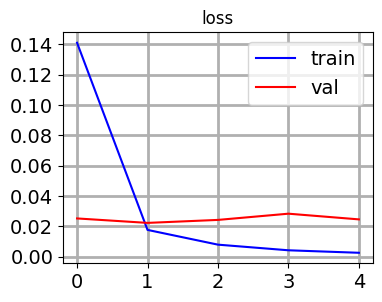

In [23]:
# 学習曲線の表示
plt.figure(figsize=(4,3))
plt.plot(history['train_loss'],label='train', c='b')
plt.plot(history['val_loss'],label='val', c='r')
plt.title('loss')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

### 推論

In [24]:
pred_by_finetuned_model = predict(test_dataloader, finetuned_model)

100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


In [25]:
# 結果をランダムに確認
for i in range(5):
    index = random.randint(0, len(test_dataset) - 1)

    print(f'テキスト　　 : {test_df["text"][index]}')
    print(f'正解固有表現 : {convert_type_ids_to_text(test_df["entities"][index])}')
    print(f'予測固有表現 : {convert_type_ids_to_text(pred_by_finetuned_model[index])}\n')

テキスト　　 : この発言が出た時、時刻は午後7時を少し回っていたが、それから4分後にはロイター通信・ドイツ通信・AP通信の各通信社は速報を出した。
正解固有表現 : [{'name': 'ロイター通信', 'span': [35, 41], 'entity_type': '法人名'}, {'name': 'ドイツ通信', 'span': [42, 47], 'entity_type': '法人名'}, {'name': 'AP通信', 'span': [48, 52], 'entity_type': '法人名'}]
予測固有表現 : [{'name': 'ロイター通信', 'span': [35, 41], 'entity_type': '法人名'}, {'name': 'ドイツ通信', 'span': [42, 47], 'entity_type': '法人名'}, {'name': 'AP通信', 'span': [48, 52], 'entity_type': '法人名'}]

テキスト　　 : シュクヴォレッキーは、「ヒトラーの下での反ユダヤ主義が偏見から殺人に変わったという事実をほとんどのドイツ人アーティストがどれほど認識していたか」を示すものとして、彼が「政治的に最も正しい映画」として特徴づけるものに参加することへの俳優の抵抗を挙げています。
正解固有表現 : [{'name': 'シュクヴォレッキー', 'span': [0, 9], 'entity_type': '人名'}, {'name': 'ヒトラー', 'span': [12, 16], 'entity_type': '人名'}, {'name': 'ドイツ', 'span': [49, 52], 'entity_type': '地名'}]
予測固有表現 : [{'name': 'シュクヴォレッキー', 'span': [0, 9], 'entity_type': '人名'}, {'name': 'ヒトラー', 'span': [12, 16], 'entity_type': '人名'}, {'name': 'ドイツ', 'span': [49, 52], 'entity_type': '地名'}]

テキスト　　 : 2002年の文科省の発表では、ロサンゼルス補習校、サンフランシスコ補習校

### 性能評価

In [26]:
evaluation_df = pd.DataFrame()

# 各クラスの予測性能を評価
for key, value in id_dict.items():
    evaluation = evaluate(test_df, test_df['entities'], pred_by_finetuned_model, type_id=value)
    evaluation_df[key] = evaluation.values()  # 各列に評価結果を格納

# 全クラスの予測性能を評価
evaluation_all = evaluate(test_df, test_df['entities'], pred_by_finetuned_model, type_id=None)
evaluation_df['ALL'] = evaluation_all.values()  #　全クラスの結果を末尾の列に格納

# 行名を設定
evaluation_df.index = evaluation_all.keys()

evaluation_df

,人名,法人名,政治的組織名,その他の組織名,地名,施設名,製品名,イベント名,ALL
正解の固有表現の数,600.000000,520.000000,259.000000,185.000000,410.000000,214.000000,251.000000,218.000000,2657.000000
AIが予測した固有表現の数,612.000000,491.000000,275.000000,235.000000,396.000000,241.000000,283.000000,229.000000,2762.000000
正解数,558.000000,427.000000,207.000000,146.000000,344.000000,186.000000,191.000000,193.000000,2252.000000
適合率,0.911765,0.869654,0.752727,0.621277,0.868687,0.771784,0.674912,0.842795,0.815351
再現率,0.930000,0.821154,0.799228,0.789189,0.839024,0.869159,0.760956,0.885321,0.847572
F1スコア,0.920792,0.844708,0.775281,0.695238,0.853598,0.817582,0.715356,0.863535,0.831150


## 銀河鉄道の夜の固有表現抽出

In [27]:
# 青空文庫から小説をダウンロード
if not os.path.exists('456_ruby_145.zip'):
    !wget https://www.aozora.gr.jp/cards/000081/files/456_ruby_145.zip
    !unzip 456_ruby_145.zip

--2024-06-27 01:05:13--  https://www.aozora.gr.jp/cards/000081/files/456_ruby_145.zip
Resolving www.aozora.gr.jp (www.aozora.gr.jp)... 59.106.13.115
Connecting to www.aozora.gr.jp (www.aozora.gr.jp)|59.106.13.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34564 (34K) [application/zip]
Saving to: ‘456_ruby_145.zip’

456_ruby_145.zip    100%[===================>]  33.75K  --.-KB/s    in 0.001s  

2024-06-27 01:05:13 (27.7 MB/s) - ‘456_ruby_145.zip’ saved [34564/34564]

Archive:  456_ruby_145.zip
Made with MacWinZipper™
  inflating: gingatetsudono_yoru.txt  


In [28]:
# ダウンロードしたtxtを確認
with open('gingatetsudono_yoru.txt', mode='r', encoding='shift_jis') as f:
    text = f.read()

print(text)

銀河鉄道の夜
宮沢賢治

-------------------------------------------------------
【テキスト中に現れる記号について】

《》：ルビ
（例）云《い》われたり

｜：ルビの付く文字列の始まりを特定する記号
（例）光る粒｜即《すなわ》ち

［＃］：入力者注　主に外字の説明や、傍点の位置の指定
　　　（数字は、JIS X 0213の面区点番号、または底本のページと行数）
（例）※［＃小書き平仮名ん、168-12］
-------------------------------------------------------

［＃３字下げ］一、午后《ごご》の授業［＃「一、午后の授業」は中見出し］

「ではみなさんは、そういうふうに川だと云《い》われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊《つる》した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指《さ》しながら、みんなに問《とい》をかけました。
　カムパネルラが手をあげました。それから四五人手をあげました。ジョバンニも手をあげようとして、急いでそのままやめました。たしかにあれがみんな星だと、いつか雑誌で読んだのでしたが、このごろはジョバンニはまるで毎日教室でもねむく、本を読むひまも読む本もないので、なんだかどんなこともよくわからないという気持ちがするのでした。
　ところが先生は早くもそれを見附《みつ》けたのでした。
「ジョバンニさん。あなたはわかっているのでしょう。」
　ジョバンニは勢《いきおい》よく立ちあがりましたが、立って見るともうはっきりとそれを答えることができないのでした。ザネリが前の席からふりかえって、ジョバンニを見てくすっとわらいました。ジョバンニはもうどぎまぎしてまっ赤になってしまいました。先生がまた云いました。
「大きな望遠鏡で銀河をよっく調べると銀河は大体何でしょう。」
　やっぱり星だとジョバンニは思いましたがこんどもすぐに答えることができませんでした。
　先生はしばらく困ったようすでしたが、眼《め》をカムパネルラの方へ向けて、
「ではカムパネルラさん。」と名指しました。するとあんなに元気に手をあげたカムパネルラが、やはりもじもじ立ち上ったままやはり答えができま

In [29]:
#前処理
# ヘッダとフッタの削除
text = re.split(r'\-{5,}',text)[2]
text = re.split(r'底本：', text)[0]
text = text.strip() # 連続する改行文字の削除

text = re.sub(r'《.+?》', '', text)     # ルビを削除
text =text.replace('｜', '')            # ルビの付を削除
text = re.sub(r'［＃.+?］', '', text)   # 入力者注を削除

text = unicodedata.normalize('NFKC', text)

print(text)

一、午后の授業

「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問をかけました。
 カムパネルラが手をあげました。それから四五人手をあげました。ジョバンニも手をあげようとして、急いでそのままやめました。たしかにあれがみんな星だと、いつか雑誌で読んだのでしたが、このごろはジョバンニはまるで毎日教室でもねむく、本を読むひまも読む本もないので、なんだかどんなこともよくわからないという気持ちがするのでした。
 ところが先生は早くもそれを見附けたのでした。
「ジョバンニさん。あなたはわかっているのでしょう。」
 ジョバンニは勢よく立ちあがりましたが、立って見るともうはっきりとそれを答えることができないのでした。ザネリが前の席からふりかえって、ジョバンニを見てくすっとわらいました。ジョバンニはもうどぎまぎしてまっ赤になってしまいました。先生がまた云いました。
「大きな望遠鏡で銀河をよっく調べると銀河は大体何でしょう。」
 やっぱり星だとジョバンニは思いましたがこんどもすぐに答えることができませんでした。
 先生はしばらく困ったようすでしたが、眼をカムパネルラの方へ向けて、
「ではカムパネルラさん。」と名指しました。するとあんなに元気に手をあげたカムパネルラが、やはりもじもじ立ち上ったままやはり答えができませんでした。
 先生は意外なようにしばらくじっとカムパネルラを見ていましたが、急いで「では。よし。」と云いながら、自分で星図を指しました。
「このぼんやりと白い銀河を大きないい望遠鏡で見ますと、もうたくさんの小さな星に見えるのです。ジョバンニさんそうでしょう。」
 ジョバンニはまっ赤になってうなずきました。けれどもいつかジョバンニの眼のなかには涙がいっぱいになりました。そうだ僕は知っていたのだ、勿論カムパネルラも知っている、それはいつかカムパネルラのお父さんの博士のうちでカムパネルラといっしょに読んだ雑誌のなかにあったのだ。それどこでなくカムパネルラは、その雑誌を読むと、すぐお父さんの書斎から巨きな本をもってきて、ぎんがというところをひろげ、まっ黒な頁いっぱいに白い点々のある美しい

In [30]:
# データセットの作成
texts = text.split('\n')
novel_dataset = TestDataset(texts = texts, tokenizer = tokenizer, max_length = MAX_LENGTH)

# データローダの作成
novel_dataloader = DataLoader(novel_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True)

In [31]:
pred_for_novel = predict(novel_dataloader, finetuned_model)

100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


In [32]:
# 各文の固有表現を取り出し
entity_dict = {}
for entity_list in pred_for_novel:
    # 固有表現がない場合はスキップ
    if len(entity_list) == 0:
        continue

    # 固有表現を振り分け
    for entity in entity_list:
        entity_type = get_type_from_id(entity['type_id'])
        if entity_type not in entity_dict:
            entity_dict[entity_type] = set()
        entity_dict[entity_type].add(entity['name'])

for key, value in entity_dict.items():
    print(f'■{key}')
    print(sorted(value), '\n')

■製品名
['、ここ', '「いいえ。', '「うん。僕だってそうだ。', '「おかしいねえ。', '「ではぼくたべよう。', '「どこへ行ったんだろう。', '「今晩は、」ジョバンニは叫び', '「何のご用ですか。', '「蝎の火ってなんだい。', 'あ', 'ああ、お前さきにおあがり。あたしはまだほしくないんだから。', 'ああ、そうだ、今夜ケンタウル祭だねえ。', 'ああ、そんなん', 'ああ、どうか。もう涼しいからね', 'ああ、ぼく銀河ステーションを通ったろうか。いまぼくたちの居るとこ、ここだろう。', 'ああ、ジョバンニ、お仕事がひどかったろう。今日は涼しくてね。わたしはずうっと工合がいいよ。', 'ああ、僕もそう思っているよ。', 'ああ、十一時かっきりには着くんだよ。', 'ああ。', 'あああたしもそう思う。けれどもおまえはどうしてそう', 'あああれ工兵', 'ああきっと', 'ああきっと一緒だよ。お母さん、窓', 'ああすぐみんな', 'ああそうです。ただいちばんのさいわいに至る', 'ああ三時ころ帰ったよ。みんなそこらをしてくれてね。', 'ああ行っておいで。川へははいらないでね。', 'あしたに', 'あす', 'あすこ', 'あたし前になんべんもお母さん', 'あなたの神さまうその神さまよ。', 'あなた方は、どちらへいらっしゃるんですか。', 'あの人どこへ行ったろう。', 'あら、インデアンですよ。インデアンですよ。ごらんなさい', 'あら、蝎の火のことならあたし知ってるわ。', 'ありがとうおじさん。おや、かおるねえさん', 'あるよ。', 'あ孔雀が居るよ。', 'いいえ、どういたしまして。どうです', 'いいえ。', 'いけないわよ。もう海からあがっていらっしゃったのよ。', 'いまも毎朝新聞をまわしに', 'いま海へ行ってらあ。', 'いやだわたあちゃんそうじゃないわよ。それはべつの方', 'いろいろ', 'う', 'うん、だけど僕、船に乗', 'うん。ぼく牛乳をとりながら見てくるよ。', 'ええ、どうも済みませんでした。', 'ええ、蝎は虫よ。だけどいい虫だわ。', 'ええええ河までは', 'ええたくさん居たわ。', 'おっかさんは、ぼくをゆるして下さるだろうか。', 'おと', 'おまえに悪口を云うの。', 'おや、変な'